# 데이터 테이블 다루기
- 데이터 결합 (merge)

In [8]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

## 주문 데이터 읽기
- 고객
- 상품
- 구매
- 구매 상세 내역

In [2]:
!curl https://raw.githubusercontent.com/StillWork/data/master/transaction.zip\
    -o transaction.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  255k  100  255k    0     0   749k      0 --:--:-- --:--:-- --:--:--  747k


In [6]:
!unzip -oq transaction.zip

In [9]:
# 고객 데이터
customer_master = pd.read_csv('customer_master.csv')
customer_master[:2]

,customer_id,customer_name,registration_date,email,gender,age,birth,pref
0,IK152942,김서준,2019-01-01 0:25,hirata_yuujirou@example.com,M,29,1990-06-10,대전광역시
1,TS808488,김예준,2019-01-01 1:13,tamura_shiori@example.com,F,33,1986-05-20,인천광역시


In [10]:
# 상품,상품명, 가격
item_master = pd.read_csv('item_master.csv')
item_master[:2]

,item_id,item_name,item_price
0,S001,PC-A,50000
1,S002,PC-B,85000


In [11]:
# 상품과 관련된 구매 내역
transaction_1 = pd.read_csv('transaction_1.csv')
transaction_1[:2]

,transaction_id,price,payment_date,customer_id
0,T0000000113,210000,2019-02-01 01:36:57,PL563502
1,T0000000114,50000,2019-02-01 01:37:23,HD678019


In [12]:
# 구매 내역 상세 데이터
transaction_detail_1 = pd.read_csv('transaction_detail_1.csv')
transaction_detail_1[:2]

,detail_id,transaction_id,item_id,quantity
0,0,T0000000113,S005,1
1,1,T0000000114,S001,1


In [13]:
transaction_1.shape, transaction_detail_1.shape

((5000, 4), (5000, 4))

In [14]:
transaction_1.transaction_id.nunique()

5000

In [15]:
transaction_detail_1.transaction_id.nunique()

4757

## 데이터 결합(유니언)
- 다른 데이터 셋이 있을 때 이를 합치는 작업
- 디폴트로 행으로 합친다

In [16]:
# 다른 구매 내역을 concat으로 합친다
transaction_2 = pd.read_csv('transaction_2.csv')
transaction = pd.concat([transaction_1, transaction_2], ignore_index=True)
transaction[:2]

,transaction_id,price,payment_date,customer_id
0,T0000000113,210000,2019-02-01 01:36:57,PL563502
1,T0000000114,50000,2019-02-01 01:37:23,HD678019


In [17]:
print(len(transaction_1))
print(len(transaction_2))
print(len(transaction))

5000
1786
6786


In [18]:
# 거래 상세 내역도 합친다
transaction_detail_2 = pd.read_csv('transaction_detail_2.csv')
transaction_detail=pd.concat([transaction_detail_1,transaction_detail_2], ignore_index=True)
transaction_detail[:2]

,detail_id,transaction_id,item_id,quantity
0,0,T0000000113,S005,1
1,1,T0000000114,S001,1


In [19]:
transaction_2.shape, transaction_detail_2.shape

((1786, 4), (2144, 4))

In [20]:
transaction_2.transaction_id.nunique()

1786

In [21]:
transaction_detail_2.transaction_id.nunique()

2029

## 매출 데이터 결합(조인)
- 행으로 합치는 것이 아니라 열을 합치는 작업
- 조인의 종류
 - 내부결합, inner join: 결합할 데이터에 모두 존재하는 데이터로만 구성
 - 외부결합, outer join: 좌측 또는 우측 데이터를 기준으로 결합하며 없는 부분은 Null
  - outer 옵션: 양측을 Or로 결합하고 없는 부분은 Null

- Inner merge
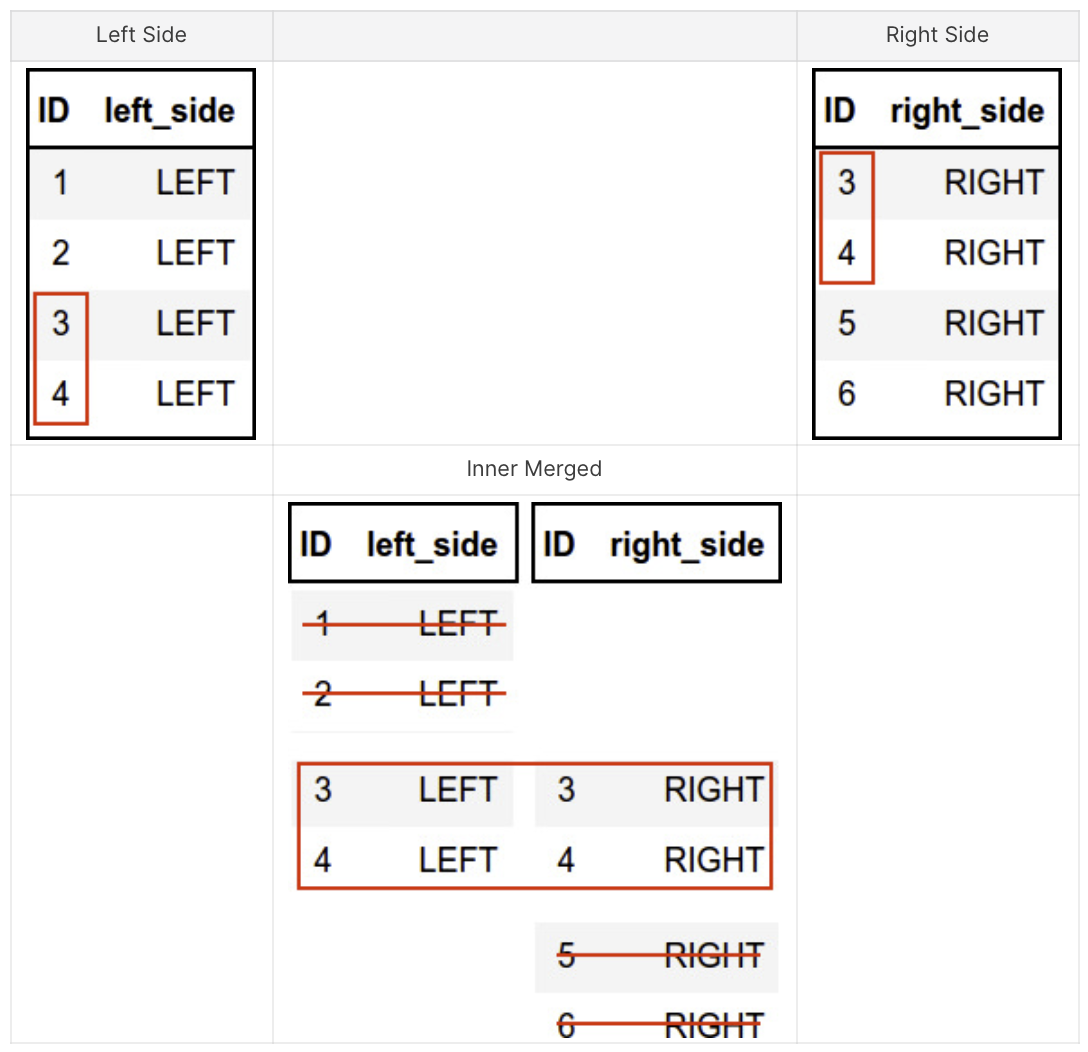

- Left merge
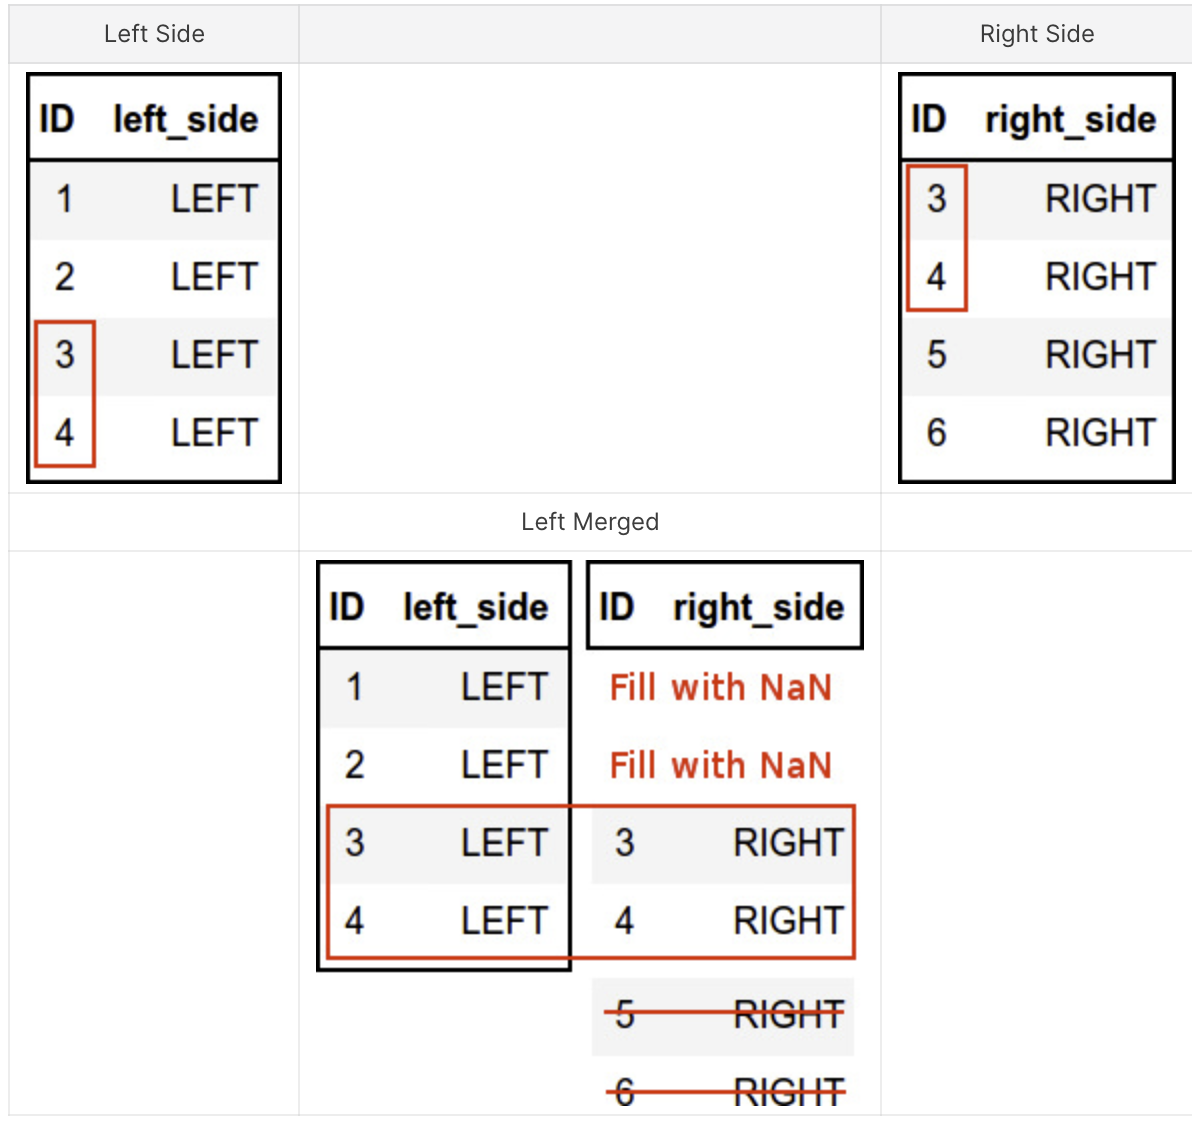

- Righr Merge
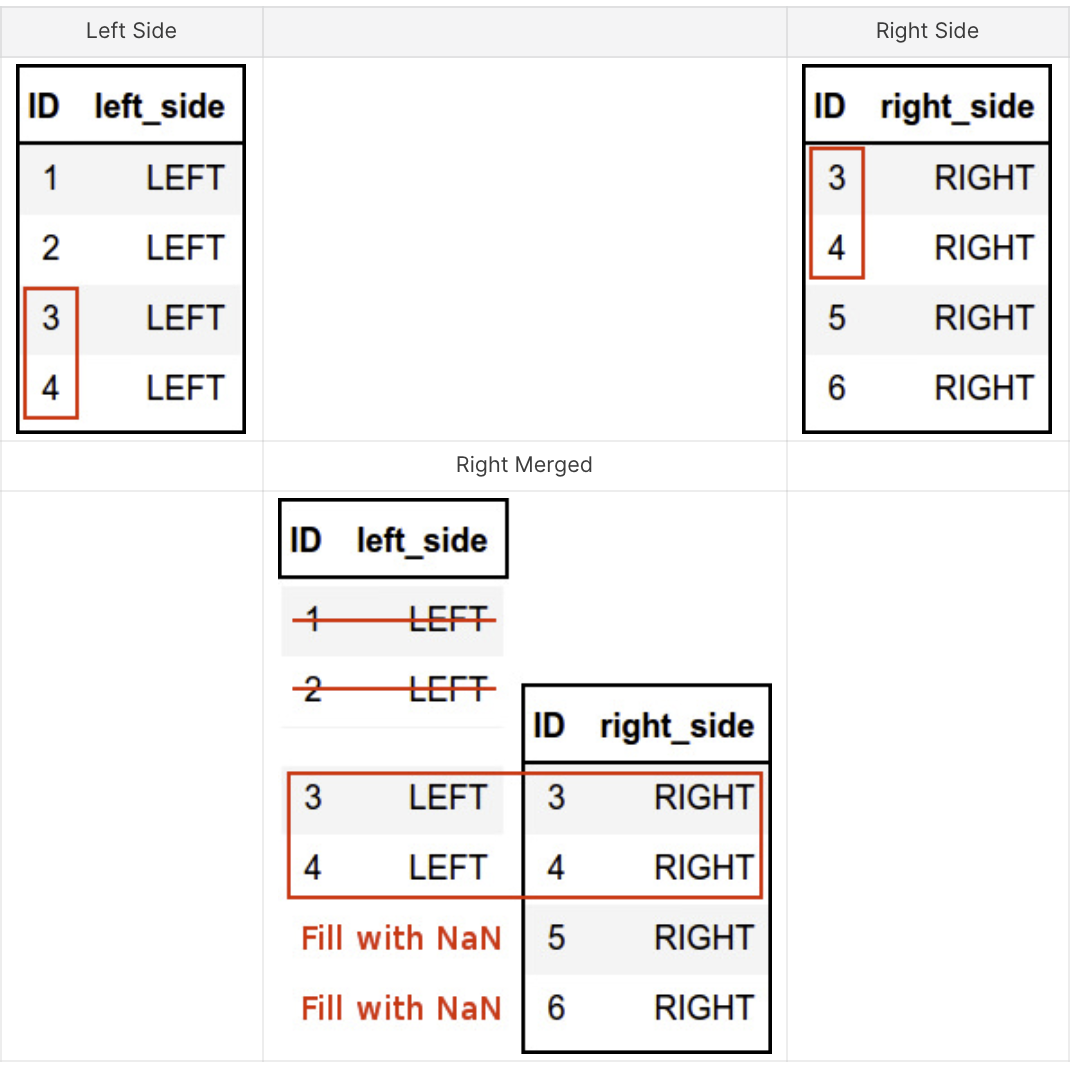

- outer merger
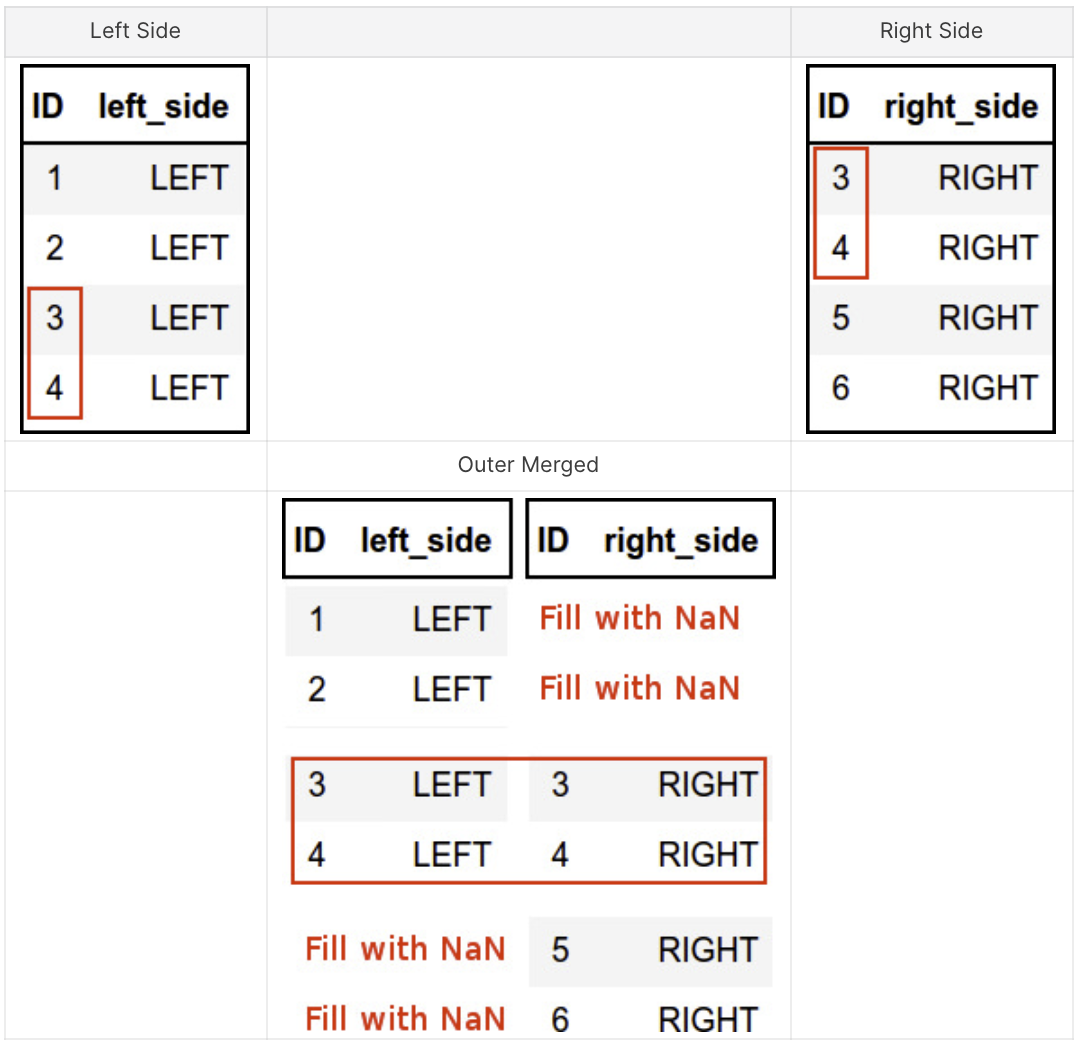

In [22]:
transaction.shape, transaction_detail.shape

((6786, 4), (7144, 4))

In [23]:
# 가장 상세한 데이터인 transaction_detail를 기준으로 조인
join_data = pd.merge(transaction_detail, 
            transaction[["transaction_id", "payment_date", "customer_id"]], 
            on="transaction_id", how="left")
print(join_data.shape)
join_data[:2]

(7144, 6)


,detail_id,transaction_id,item_id,quantity,payment_date,customer_id
0,0,T0000000113,S005,1,2019-02-01 01:36:57,PL563502
1,1,T0000000114,S001,1,2019-02-01 01:37:23,HD678019


In [24]:
join_data.isnull().sum()

detail_id         0
transaction_id    0
item_id           0
quantity          0
payment_date      0
customer_id       0
dtype: int64

## 마스터데이터 결합(조인)

In [25]:
customer_master.shape, item_master.shape

((5000, 8), (5, 3))

In [26]:
join_data = pd.merge(join_data, customer_master, on="customer_id", how="left")
join_data = pd.merge(join_data, item_master, on="item_id", how="left")
print(join_data.shape)
join_data[:2]

(7144, 15)


,detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,email,gender,age,birth,pref,item_name,item_price
0,0,T0000000113,S005,1,2019-02-01 01:36:57,PL563502,김태경,2019-01-07 14:34,imoto_yoshimasa@example.com,M,30,1989-07-15,대전광역시,PC-E,210000
1,1,T0000000114,S001,1,2019-02-01 01:37:23,HD678019,김영웅,2019-01-27 18:00,mifune_rokurou@example.com,M,73,1945-11-29,서울특별시,PC-A,50000


## 필요한 데이터 컬럼을 추가
- 하나의 테이블로 만들었다
- 매출액 컬럼을 계산하여 추가 (price)

In [27]:
join_data["price"] = join_data["quantity"] * join_data["item_price"]
join_data[["quantity", "item_price","price"]][:2]

,quantity,item_price,price
0,1,210000,210000
1,1,50000,50000


In [28]:
join_data[:2]

,detail_id,transaction_id,item_id,quantity,payment_date,customer_id,customer_name,registration_date,email,gender,age,birth,pref,item_name,item_price,price
0,0,T0000000113,S005,1,2019-02-01 01:36:57,PL563502,김태경,2019-01-07 14:34,imoto_yoshimasa@example.com,M,30,1989-07-15,대전광역시,PC-E,210000,210000
1,1,T0000000114,S001,1,2019-02-01 01:37:23,HD678019,김영웅,2019-01-27 18:00,mifune_rokurou@example.com,M,73,1945-11-29,서울특별시,PC-A,50000,50000


In [29]:
# 데이터 가공 결과 확인
print(join_data["price"].sum())
print(transaction["price"].sum())

971135000
971135000


In [30]:
print(join_data["payment_date"].min())
print(join_data["payment_date"].max())

2019-02-01 01:36:57
2019-07-31 23:41:38


# 월별 데이터 파악

In [31]:
join_data.dtypes

detail_id             int64
transaction_id       object
item_id              object
quantity              int64
payment_date         object
customer_id          object
customer_name        object
registration_date    object
email                object
gender               object
age                   int64
birth                object
pref                 object
item_name            object
item_price            int64
price                 int64
dtype: object

In [32]:
join_data["payment_date"] = pd.to_datetime(join_data["payment_date"])
join_data["payment_month"] = join_data["payment_date"].dt.strftime("%Y%m")
join_data[["payment_date", "payment_month"]][:2]

,payment_date,payment_month
0,2019-02-01 01:36:57,201902
1,2019-02-01 01:37:23,201902


In [33]:
join_data.groupby("payment_month").sum()["price"]

payment_month
201902    160185000
201903    160370000
201904    160510000
201905    155420000
201906    164030000
201907    170620000
Name: price, dtype: int64

In [34]:
join_data.groupby(["payment_month","item_name"]).sum()[["price", "quantity"]]

price  quantity
payment_month item_name                    
201902        PC-A       24150000       483
              PC-B       25245000       297
              PC-C       19800000       165
              PC-D       31140000       173
              PC-E       59850000       285
201903        PC-A       26000000       520
              PC-B       25500000       300
              PC-C       19080000       159
              PC-D       25740000       143
              PC-E       64050000       305
201904        PC-A       25900000       518
              PC-B       23460000       276
              PC-C       21960000       183
              PC-D       24300000       135
              PC-E       64890000       309
201905        PC-A       24850000       497
              PC-B       25330000       298
              PC-C       20520000       171
              PC-D       25920000       144
              PC-E       58800000       280
201906        PC-A       26000000       520
              PC-B       23970000       282
              PC-C       21840000       182
              PC-D       28800000       160
              PC-E       63420000       302
201907        PC-A       25250000       505
              PC-B       28220000       332
              PC-C       19440000       162
              PC-D       26100000       145
              PC-E       71610000       341

In [60]:
pd.pivot_table(join_data, index='item_name', columns='payment_month', values=['price', 'quantity'], aggfunc='sum')

price                                                    \
payment_month    201902    201903    201904    201905    201906    201907   
item_name                                                                   
PC-A           24150000  26000000  25900000  24850000  26000000  25250000   
PC-B           25245000  25500000  23460000  25330000  23970000  28220000   
PC-C           19800000  19080000  21960000  20520000  21840000  19440000   
PC-D           31140000  25740000  24300000  25920000  28800000  26100000   
PC-E           59850000  64050000  64890000  58800000  63420000  71610000   

              quantity                                     
payment_month   201902 201903 201904 201905 201906 201907  
item_name                                                  
PC-A               483    520    518    497    520    505  
PC-B               297    300    276    298    282    332  
PC-C               165    159    183    171    182    162  
PC-D               173    143    135    144    160    145  
PC-E               285    305    309    280    302    341

## 상품별 매출 추이

In [36]:
graph_data = pd.pivot_table(join_data, index='payment_month', columns='item_name', values='price', aggfunc='sum')
graph_data.head()

item_name,PC-A,PC-B,PC-C,PC-D,PC-E
payment_month,,,,,
201902,24150000,25245000,19800000,31140000,59850000
201903,26000000,25500000,19080000,25740000,64050000
201904,25900000,23460000,21960000,24300000,64890000
201905,24850000,25330000,20520000,25920000,58800000
201906,26000000,23970000,21840000,28800000,63420000


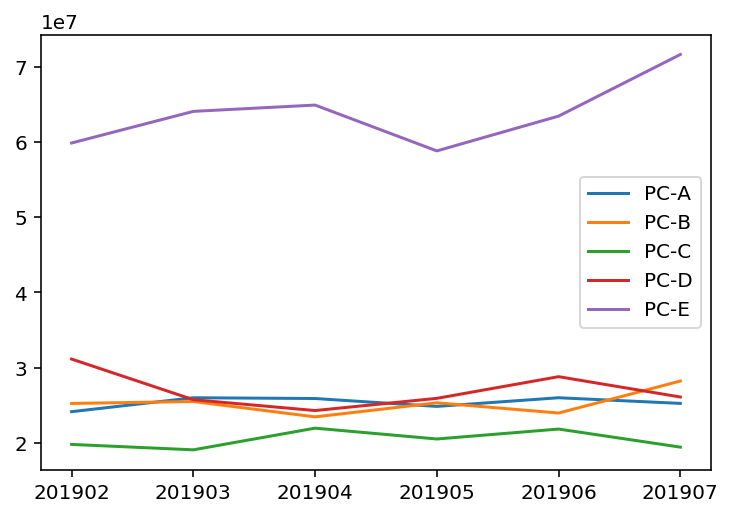

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(graph_data.index), graph_data["PC-A"], label='PC-A')
plt.plot(list(graph_data.index), graph_data["PC-B"], label='PC-B')
plt.plot(list(graph_data.index), graph_data["PC-C"], label='PC-C')
plt.plot(list(graph_data.index), graph_data["PC-D"], label='PC-D')
plt.plot(list(graph_data.index), graph_data["PC-E"], label='PC-E')
plt.legend()  